# Applying Shapley values to a regression model of simulated sales

This notebook builds a simulated dataset for a fictional seasonal product and fits a LightGBM model. This data is then used to illustrate why exact Shapley values might not always be accurate versus the ground truth.

In [1]:
import importlib
import os
import random
import shap

import itertools as it
import lightgbm as lgb
import numpy as np
import pandas as pd

from pandas.api.types import CategoricalDtype

from scipy.linalg import eigh

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

from mizani.formatters import percent_format
from plotnine import ggplot, aes, geom_line, facet_wrap, theme, \
    labs, geom_vline, geom_text, geom_area, geom_point, geom_histogram, \
    coord_flip, geom_bar, geom_abline, geom_hline, xlim, scale_x_continuous, \
    scale_color_manual, scale_fill_manual, scale_fill_discrete, \
    scale_y_continuous, ylim
from seaborn import pairplot

import warnings
warnings.filterwarnings('ignore')

import shapley
from regression_diagnostics import RegressionDiagnostics

## Globals

In [2]:
MY_PATH = os.path.dirname(os.getcwd())

## Build dataset

Simulate metrics for a fictional product that is influenced by seasonality,
weather, and promotions

In [3]:
def build_metrics(num_years=4, seed=None):
    """Build simulated metrics for a fictional (seasonal) product
    
    Builds metrics including weather and promotional 'deals'
    
    Parameters
    ----------
    num_years : int
        Number of 'years' to generate data for
        
    seed : int, optional default=None
        Random seed for numpy randomstate
        
    Returns
    -------
    df_base : pandas DataFrame
        Simulated metrics
    """
    if seed:
        np.random.seed(seed)
    
    num_days = 364
    
    # Seasonality
    x_seasonality = list((np.sin(np.arange(-0.5, 1.5, 2 / num_days) * np.pi) + 1) / 2)
    x_seasonality *= num_years

    # Rainy days
    rainy_days = np.random.choice(range(num_days * num_years),
                                  np.int(0.25 * num_days * num_years),
                                  replace = False)
    x_rain = [x in rainy_days for x in range(
        num_days * num_years)] * np.random.exponential(1.5, num_days * num_years)

    # Sun hours and temperature variation from long-term (correlated)
    x_sun_temp = np.random.normal(0, 1, size = (2, num_days * num_years))

    # Covariance matrix
    r = np.array([
        [1, 0.6],
        [0.6, 1]
        ])

    # Get eigenvalues and eigenvectors
    evals, evecs = eigh(r)
    # Construct c, so c*c^T = r
    c = np.dot(evecs, np.diag(np.sqrt(evals)))
    x_sun_temp_new = np.dot(c, x_sun_temp)

    x_sun = x_sun_temp_new[0,]
    x_temp = x_sun_temp_new[1,]

    # Deal weeks (arbitrarily restricted to middle of year)
    no_of_deals = 4
    deal_weeks = np.random.choice(range(16, 38),
                                  no_of_deals * num_years, replace = False)
    deal_weeks_df = pd.DataFrame(zip(
        it.chain.from_iterable(
            it.repeat(x,no_of_deals) for x in range(num_years)),
        deal_weeks), columns = ["YEAR", "WEEK"]).sort_values(
        ["YEAR", "WEEK"]).reset_index(drop = True)
    deal_weeks_df["DEAL"] = 1

    # Build data frame
    df_base = pd.DataFrame(zip(
        [x % num_days for x in range(num_days * num_years)],
        x_seasonality), columns = ["DOY", "SEASONAL"]).assign(
        RAIN = x_rain,
        SUN_HOURS = x_sun,
        MAX_TEMP = x_temp,
    )
    df_base["WEEK"] = df_base.DOY.apply(lambda x: int(x / 7) % 52)
    df_base["YEAR"] = list(it.chain.from_iterable(
        it.repeat(x, num_days) for x in range(num_years)))

    df_base = df_base.merge(deal_weeks_df, how = "left",
                            on = ["YEAR", "WEEK"]).fillna(0)
    
    return df_base[["YEAR", "WEEK", "DOY", "SEASONAL", "RAIN",
                    "SUN_HOURS", "MAX_TEMP", "DEAL"]]

In [4]:
# Generate metrics for a 4 year period
metrics = build_metrics(num_years=4, seed=11)
metrics.head()

,YEAR,WEEK,DOY,SEASONAL,RAIN,SUN_HOURS,MAX_TEMP,DEAL
0,0,0,0,0.000000,0.000000,0.329428,-0.541991,0.0
1,0,0,1,0.000074,0.000000,0.516410,-0.360398,0.0
2,0,0,2,0.000298,0.407041,2.328481,2.180740,0.0
3,0,0,3,0.000670,0.000000,0.933403,0.819759,0.0
4,0,0,4,0.001191,0.000000,0.024442,0.710872,0.0


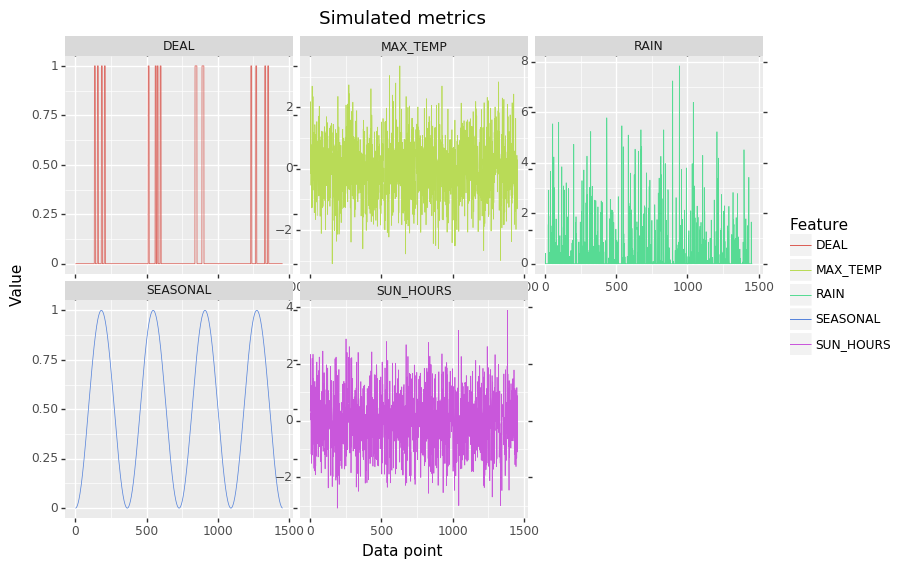

<ggplot: (-9223371923030220277)>

In [5]:
# Plot metrics
(ggplot(metrics.drop(["WEEK","YEAR","DOY"], axis=1).reset_index().melt(
    id_vars=["index"]),
       aes(x="index", y="value", colour="variable")) +
 geom_line(size=0.3) +
 facet_wrap("~variable", scales="free") +
 theme(figure_size=(9,6)) +
 labs(title="Simulated metrics",
      x="Data point",
      y="Value",
      color="Feature")
)

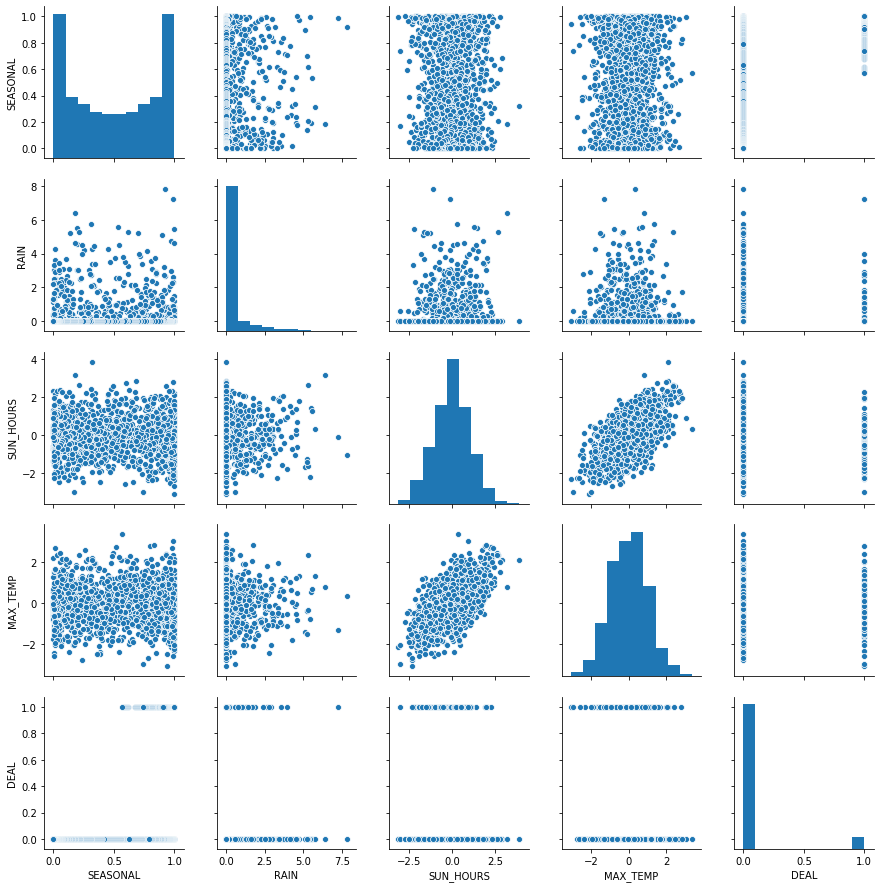

In [6]:
# Correlation plots
pairplot(metrics.drop(["WEEK","YEAR","DOY"], axis=1))

In [7]:
def build_data(metrics, coefs, use_noise=True, seed=None):
    """Build 'actual' values for simulated sales from standardised metrics
    
    Parameters
    ----------
    metrics : pandas DataFrame
        data frame containing metrics generated by build_metrics
        
    coefs : dict(metric: value)
        lookup dictionary of metric to coefficient
        
    use_noise : bool, optional default=True
        whether or not to generate random noise around the base
        
    seed : int, optional default=None
        Random seed for numpy randomstate
        
    Returns
    -------
    metric_contribs : pandas DataFrame
        Simulated effects of metrics
    """
    if seed:
        np.random.seed(seed)
    
    # Number of data points in metrics
    num_rows = metrics.shape[0]
    
    # Get random normal noise if required
    if use_noise == True:
        noise_factor = np.random.normal(1, coefs["NOISE"], num_rows)
    else:
        noise_factor = 1

    # Build data
    metric_contribs = pd.DataFrame(
        (coefs["INTERCEPT"] + metrics["SEASONAL"] * coefs["SEASONAL"]),
        columns=["SEASONAL"])
    
    metric_contribs = metric_contribs.assign(
        NOISE = noise_factor * metric_contribs["SEASONAL"] - metric_contribs["SEASONAL"]
    )
    
    base = metric_contribs["SEASONAL"]
    
    # Main effects    
    metric_contribs = metric_contribs.assign(
        RAIN = metrics["RAIN"] * coefs["RAIN"] * base / 2,
        MAX_TEMP = metrics["MAX_TEMP"] * coefs["MAX_TEMP"] * base,
        MAX_TEMP_LAG1 = coefs["MAX_TEMP_LAG1"] * metrics["MAX_TEMP"].shift(1, fill_value=0) * base,
        SUN_HOURS = metrics["SUN_HOURS"] * coefs["SUN_HOURS"] * base,
        DEAL = coefs["DEAL"] * metrics["DEAL"] * base * (np.random.normal(
            1, 0.25, size=num_rows))
    )

    # Interactions
    metric_contribs = metric_contribs.assign(
        MAX_TEMP_DEAL = metrics["MAX_TEMP"] * metrics["DEAL"] * coefs["MAX_TEMP_DEAL"] * base,
        RAIN_DEAL = metrics["RAIN"] * metrics["DEAL"] * coefs["RAIN_DEAL"] * base)
    
    metric_contribs["Y"] = [max(x, 0) for x in metric_contribs.sum(axis=1)]
    
    return metric_contribs

In [8]:
# Build simulated effects of the metrics
coefs = {
    "INTERCEPT":100,
    "SEASONAL": 1500,
    "DEAL": 0.6,
    "RAIN": -0.08,
    "MAX_TEMP": 0.15,
    "MAX_TEMP_LAG1": 0.05,
    "SUN_HOURS": 0.1,
    "MAX_TEMP_DEAL": 0.05,
    "RAIN_DEAL": 0.066,
    "NOISE": 0.005
}

sales = build_data(metrics, coefs, use_noise=True, seed=42)
sales

,SEASONAL,NOISE,RAIN,MAX_TEMP,MAX_TEMP_LAG1,SUN_HOURS,DEAL,MAX_TEMP_DEAL,RAIN_DEAL,Y
0,100.000000,0.248357,-0.000000,-8.129870,0.000000,3.294282,0.0,-0.0,0.0,95.412768
1,100.111732,-0.069209,-0.000000,-5.412003,-2.712985,5.169867,0.0,-0.0,0.0,97.087403
2,100.446895,0.325292,-1.635439,32.857281,-1.810040,23.388867,0.0,0.0,0.0,153.572854
3,101.005388,0.769171,-0.000000,12.420005,11.013323,9.427869,0.0,0.0,0.0,134.635757
4,101.787046,-0.119169,-0.000000,10.853639,4.172040,0.248783,0.0,0.0,0.0,116.942340
...,...,...,...,...,...,...,...,...,...,...
1451,102.791635,0.874867,-0.000000,6.751515,-3.313102,11.948123,0.0,0.0,0.0,119.053038
1452,101.787046,0.122528,-0.000000,6.695433,2.228511,-2.492213,0.0,0.0,0.0,108.341303
1453,101.005388,1.313920,-0.000000,-19.758409,2.214672,-11.208175,0.0,-0.0,0.0,73.567396
1454,100.446895,0.284018,-0.000000,-0.706461,-6.549719,-0.857662,0.0,-0.0,0.0,92.617071


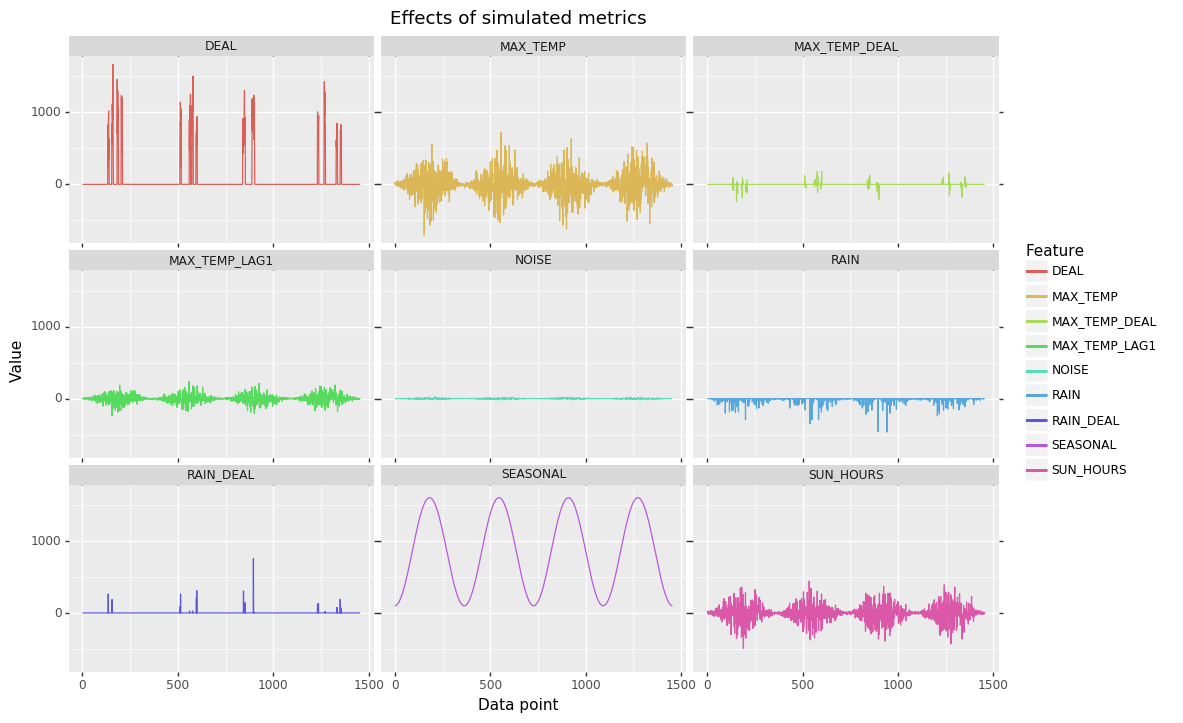

<ggplot: (113826839921)>

In [9]:
# Plot simulated effects of the metrics
(ggplot(sales.drop("Y", axis=1).reset_index().melt(
    id_vars="index"),
        aes(x="index", y="value", color="variable")) +
 geom_line() +
 facet_wrap("~variable", ncol=3) +
 theme(figure_size=(12,8)) +
 labs(title="Effects of simulated metrics",
      x="Data point",
      y="Value",
      color="Feature")
)

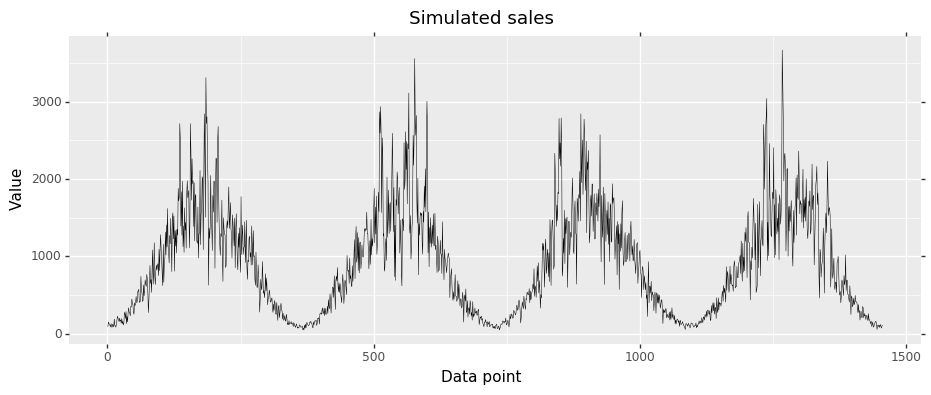

<ggplot: (113826898103)>

In [10]:
# Plot final simulated sales
(ggplot(sales.reset_index(),
        aes(x = "index", y = "Y")) +
 geom_line(size=0.2) +
 theme(figure_size=(11,4)) +
 labs(title="Simulated sales",
      x="Data point",
      y="Value")
)

In [11]:
# Values of DOY corresponding to mean of SEASONAL feature (within 1%)
seasonal_mean = sales.SEASONAL.mean()
metrics[["DOY"]].assign(SEASONAL = sales.SEASONAL).query(
    "SEASONAL > @seasonal_mean * 0.99 and SEASONAL < @seasonal_mean * 1.01")

,DOY,SEASONAL
91,91,850.0
273,273,850.0
455,91,850.0
637,273,850.0
819,91,850.0
1001,273,850.0
1183,91,850.0
1365,273,850.0


## Case 1: Simple dataset

Compare exact Shapley values with an 'adjusted' version for a model of seasonal demand and deals.

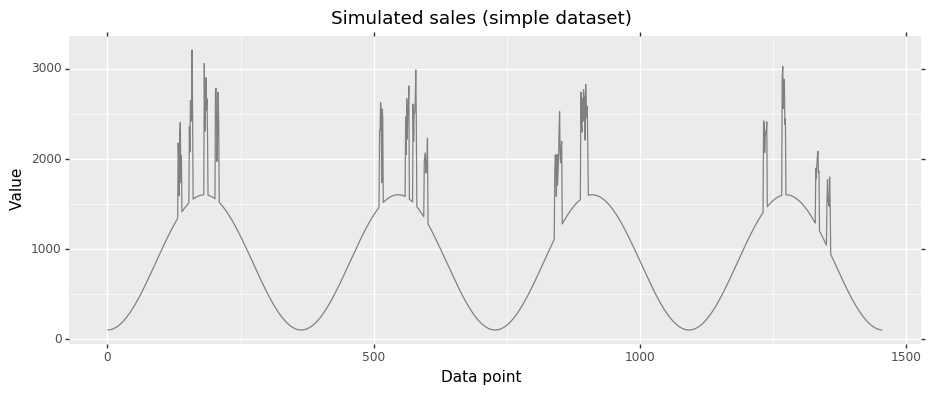

<ggplot: (113824731414)>

In [12]:
X_1 = metrics[["DOY", "DEAL"]].assign(
    Y = sales[["SEASONAL", "DEAL"]].sum(axis=1))

(ggplot(X_1.reset_index(),
        aes(x = "index", y = "Y")) +
 geom_line(color="grey") +
 theme(figure_size=(11,4)) +
 labs(x="Data point", y="Value", title="Simulated sales (simple dataset)")
)

In [13]:
# Train/test split (save most recent year for test data)
split_point_1 = X_1.shape[0]-363

X_train_1 = X_1.loc[:split_point_1].drop("Y", axis=1)
y_train_1 = X_1.loc[:split_point_1, "Y"]

X_test_1 = X_1.loc[(split_point_1-1):].drop("Y", axis=1)
y_test_1 = X_1.loc[(split_point_1-1):, "Y"]

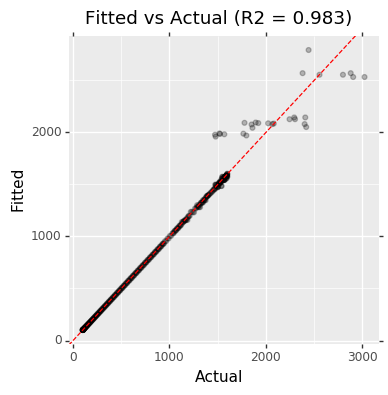

<ggplot: (-9223371923030046951)>

In [14]:
# Fit model
params_1 = {
    "boosting_type": "dart",
    "n_estimators": 2500,
    "monotone_constraints": [0, 1]
}

lgb_model_1 = lgb.LGBMRegressor(**params_1)
lgb_model_1.fit(X_train_1, y_train_1)

# Get diagnostics
diagnostics_1 = RegressionDiagnostics(lgb_model_1)
diagnostics_1.fit(X_test_1, y_test_1)

diagnostics_1.fitted_actual(sample_frac=1.0)

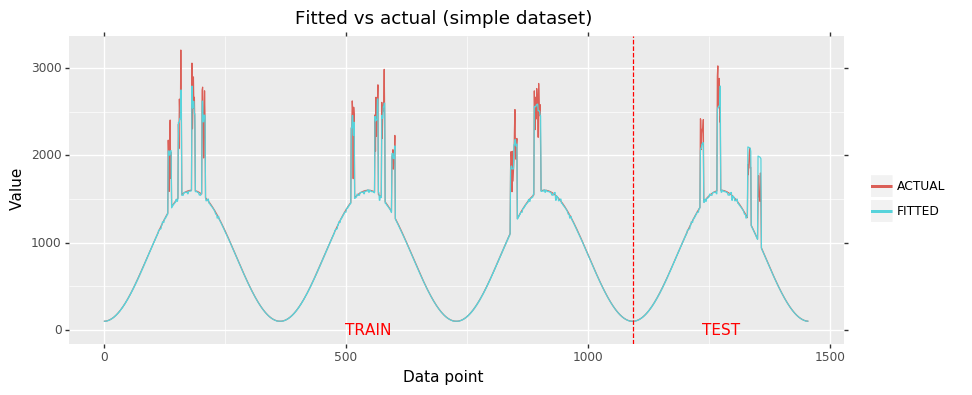

<ggplot: (113824764599)>

In [15]:
# Get predicted values for all data points
yhat_all_1a = metrics[["YEAR", "DOY"]].assign(
    ACTUAL = X_1.Y,
    FITTED = lgb_model_1.predict(X_1.drop("Y", axis=1))
)

# Train and test labels for plot
train_test_label_1a = pd.DataFrame(
    {"x": [split_point_1 * 0.5 ,
           split_point_1 + (metrics.shape[0] - split_point_1) * 0.5],
     "y": [0, 0],
     "label": ["TRAIN", "TEST"]})

# Plot actual vs predicted
(ggplot(yhat_all_1a.drop(["YEAR", "DOY"], axis=1).reset_index().melt(
    id_vars="index"),
        aes(x="index", y="value", colour="variable")) +
 geom_line() +
 geom_vline(aes(xintercept=split_point_1), colour="red",
           linetype="dashed") +
 geom_text(train_test_label_1a,
           aes(x="x", y="y", label="label"),
          inherit_aes=False, colour="red") +
 theme(figure_size=(10,4)) +
 labs(x="Data point", y="Value",
      title="Fitted vs actual (simple dataset)",
      color="")
)

### Shapley values (exact, default DOY = 0)

In [16]:
# Calculate Shapley values
shapley_est_1a = shapley.ShapleyEstimator(model=lgb_model_1,
                                         max_iter=2,
                                         tol=-np.inf,
                                         default_values={"DOY":0, "DEAL":0})
shapley_est_1a.fit(X_test_1)

Start time: 19:31:20.757388
Iteration:      1, Difference: 1.000000, Time: 19:31:21.928388, Coalitions seen: 66.67%
Iteration:      2, Difference: 0.125803, Time: 19:31:22.087388, Coalitions seen: 100.00%
Finished
Iteration:      2, Difference: 0.125803, Time: 19:31:22.087388, Coalitions seen: 100.00%


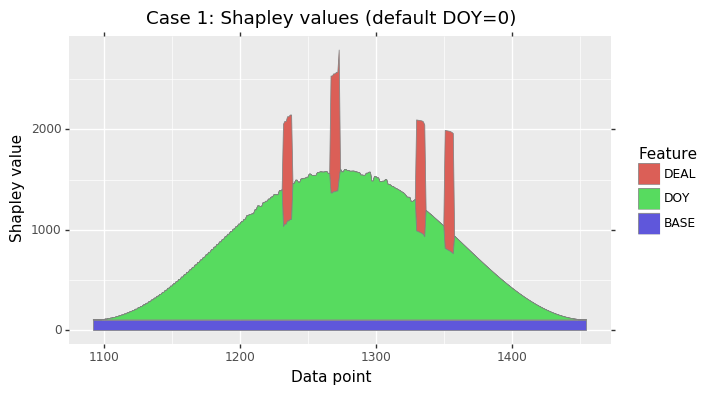

<ggplot: (-9223371923027640183)>

In [17]:
# Plot Shapley values
shapley_est_1a_melt = shapley_est_1a.get_shapley_values().reset_index().melt(
    id_vars="index")

shapley_est_1a_melt = shapley_est_1a_melt.assign(
    variable = pd.Categorical(shapley_est_1a_melt["variable"],
                              categories=["DEAL", "DOY", "BASE"],
                              ordered=False))

(ggplot(shapley_est_1a_melt,
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.3) +
 theme(figure_size = (7, 4)) +
 labs(title="Case 1: Shapley values (default DOY=0)",
     x="Data point",
     y="Shapley value",
     fill="Feature")
)

### Shapley values (exact, default DOY = 91)

In [18]:
doy_default_1b = 91
shapley_est_base_1b = lgb_model_1.predict(pd.DataFrame({"DOY":[doy_default_1b], "DEAL": [0]}))

In [19]:
# Calculate Shapley values
shapley_est_1b = shapley.ShapleyEstimator(model=lgb_model_1,
                                         max_iter=2,
                                         tol=-np.inf,
                                         default_values={"DOY":doy_default_1b, "DEAL": 0},)
shapley_est_1b.fit(X_test_1)

Start time: 19:31:23.371359
Iteration:      1, Difference: 1.000000, Time: 19:31:23.429361, Coalitions seen: 66.67%
Iteration:      2, Difference: 0.037879, Time: 19:31:23.443360, Coalitions seen: 100.00%
Finished
Iteration:      2, Difference: 0.037879, Time: 19:31:23.443360, Coalitions seen: 100.00%


In [20]:
# Put the Shapley values into a dataframe
shapley_values_1b = shapley_est_1b.get_shapley_values()

shapley_values_1b = shapley_values_1b.assign(
    BASE = shapley_values_1b.BASE + min(shapley_est_1b.get_shapley_values().DOY),
    DOY = shapley_values_1b.DOY - min(shapley_est_1b.get_shapley_values().DOY)
)
shapley_values_1b

,BASE,DOY,DEAL
1092,100.860633,0.000000,0.0
1093,100.860633,0.000000,0.0
1094,100.860633,0.000000,0.0
1095,100.860633,0.000000,0.0
1096,100.860633,0.000000,0.0
...,...,...,...
1451,100.860633,0.903173,0.0
1452,100.860633,0.903173,0.0
1453,100.860633,0.903173,0.0
1454,100.860633,0.903173,0.0


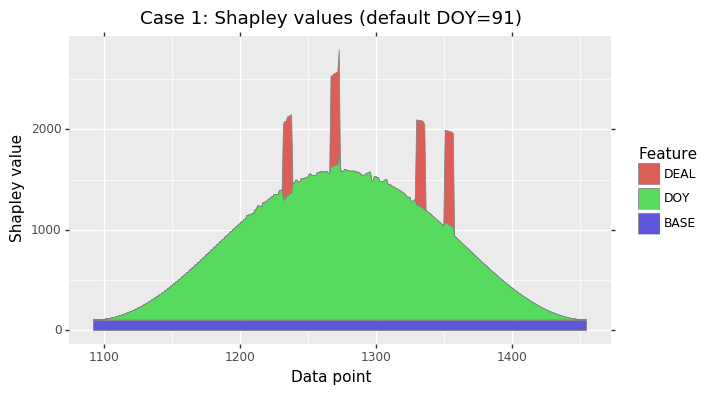

<ggplot: (-9223371923027645580)>

In [21]:
# Plot Shapley values
shapley_est_1b_melt = shapley_values_1b.reset_index().melt(
    id_vars="index")

shapley_est_1b_melt = shapley_est_1b_melt.assign(
    variable = pd.Categorical(shapley_est_1b_melt["variable"],
                              categories=["DEAL", "DOY", "BASE"],
                              ordered=False))

(ggplot(shapley_est_1b_melt,
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.3) +
 theme(figure_size = (7, 4)) +
 labs(title="Case 1: Shapley values (default DOY={})".format(doy_default_1b),
     x="Data point",
     y="Shapley value",
     fill="Feature")
)

### Shapley values (DOY always first)

In [22]:
# Calculate Shapley values
shapley_est_1c = shapley.ShapleyEstimator(model=lgb_model_1,
                                          max_iter=1,
                                          base_features=["DOY"],
                                          tol=-np.inf)
shapley_est_1c.fit(X_test_1)

Start time: 19:31:24.878358
Iteration:      1, Difference: 1.000000, Time: 19:31:24.921362, Coalitions seen: 100.00%
Finished
Iteration:      1, Difference: 1.000000, Time: 19:31:24.921362, Coalitions seen: 100.00%


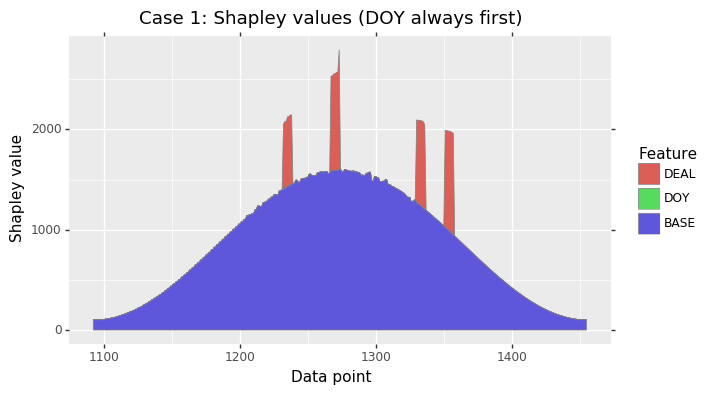

<ggplot: (113827133174)>

In [23]:
# Plot Shapley values
shapley_est_1c_melt = shapley_est_1c.get_shapley_values().assign(DOY = 0).reset_index().melt(
    id_vars="index")
shapley_est_1c_melt = shapley_est_1c_melt.assign(
    variable = pd.Categorical(shapley_est_1c_melt["variable"],
                              categories=["DEAL", "DOY", "BASE"],
                              ordered=False))

(ggplot(shapley_est_1c_melt,
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.3) +
 theme(figure_size = (7, 4)) +
 labs(title="Case 1: Shapley values (DOY always first)",
      x="Data point",
      y="Shapley value",
      fill="Feature"
     )
)

### SHAP values

In [24]:
shap.initjs()

In [25]:
# Build SHAP explainer
explainer_1 = shap.TreeExplainer(lgb_model_1)
shap_values_1 = explainer_1.shap_values(X_test_1)

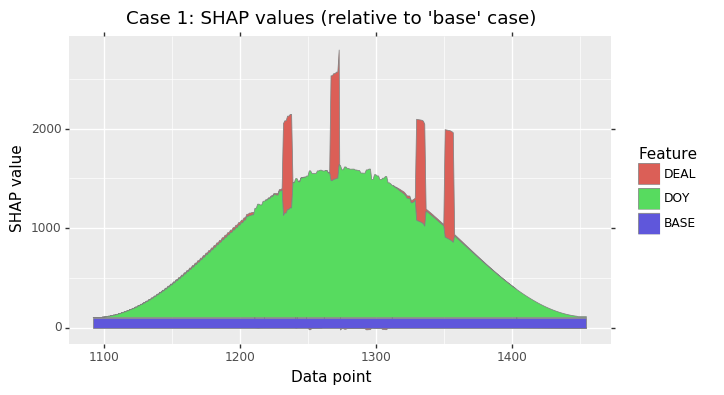

<ggplot: (-9223371923027645636)>

In [26]:
# Get SHAP values for DEAL==0 & DOY==0 (i.e. base case, rather than global average) 
shap_values_base_1 = explainer_1.shap_values(
    pd.DataFrame({x:[0] for x in X_test_1.columns}))

# Subtract the base values from the SHAP output
shap_values_adj_1 = pd.DataFrame(shap_values_1 - shap_values_base_1,
                               columns=["DOY", "DEAL"]).assign(
    BASE=explainer_1.expected_value + np.sum(shap_values_base_1),
    index=X_test_1.index)

# Melt the data frame for plotting
shap_values_adj_melt_1 = shap_values_adj_1.melt(
    id_vars="index")
shap_values_adj_melt_1 = shap_values_adj_melt_1.assign(
    variable = pd.Categorical(shap_values_adj_melt_1["variable"],
                              categories=["DEAL", "DOY", "BASE"],
                              ordered=False))

(ggplot(shap_values_adj_melt_1,
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.3) +
 theme(figure_size = (7, 4)) +
 labs(title="Case 1: SHAP values (relative to 'base' case)",
     x="Data point",
     y="SHAP value",
     fill="Feature")
)

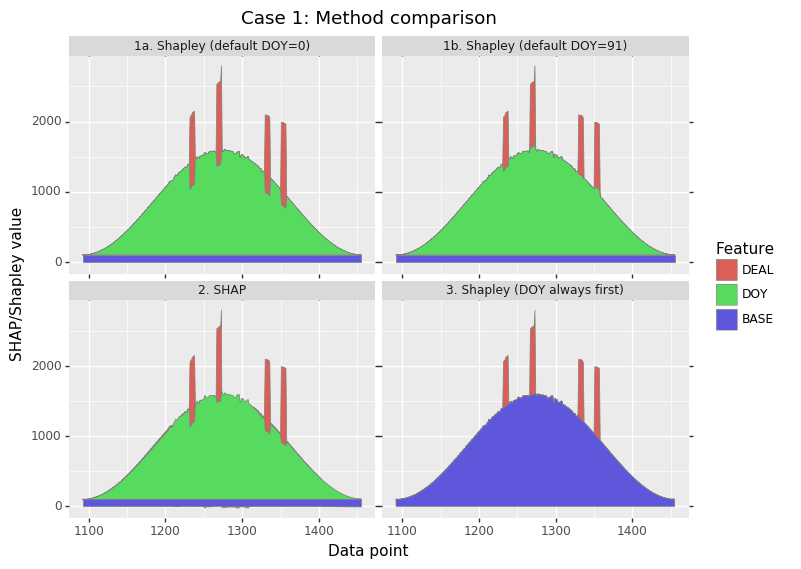

<ggplot: (-9223371923027663991)>

In [27]:
# Combine all results into a single plot object
shapley_results_1 = pd.concat(
    [shap_values_adj_melt_1.assign(method="2. SHAP"),
     shapley_est_1a_melt.assign(method="1a. Shapley (default DOY=0)"),
     shapley_est_1b_melt.assign(method="1b. Shapley (default DOY={})".format(doy_default_1b)),
     shapley_est_1c_melt.assign(method="3. Shapley (DOY always first)")])

(ggplot(shapley_results_1,
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.3) +
 theme(figure_size = (8, 6)) +
 labs(title="Case 1: Method comparison",
     x="Data point",
     y="SHAP/Shapley value",
     fill="Feature") +
 facet_wrap("~method", ncol=2)
)

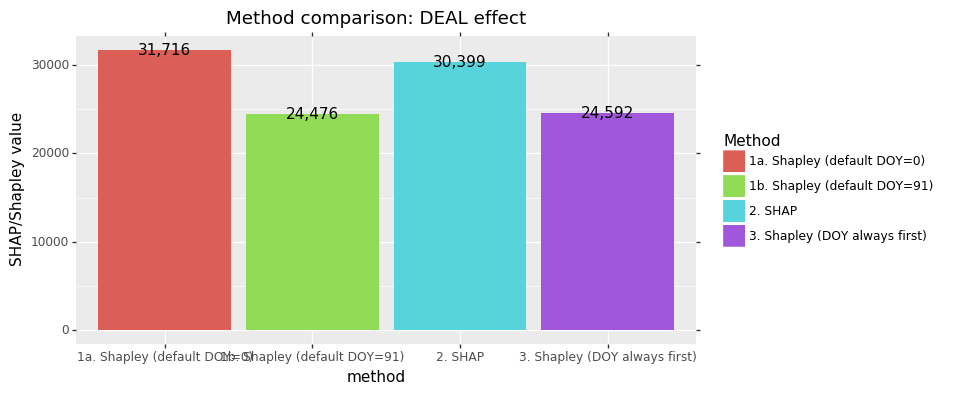

<ggplot: (-9223371923027453408)>

In [28]:
# Compare methods for aggregated effect of DEAL
(ggplot(shapley_results_1.drop("index", axis=1).query(
    "variable == 'DEAL'").groupby(["method"], as_index=False).sum(),
        aes(x="method", y="value", fill="method")) +
 geom_bar(stat="identity") +
 geom_text(aes(label="value"),
           format_string="{:6,.0f}") +
 theme(figure_size = (8, 4)) +
 labs(title="Method comparison: DEAL effect",
     y="SHAP/Shapley value",
     fill="Method")
)

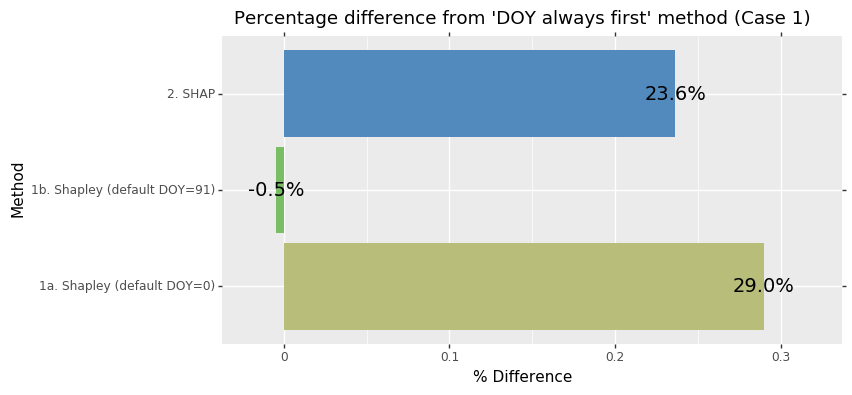

<ggplot: (-9223371923027359214)>

In [29]:
shapley_results_1_deal = shapley_results_1.drop(
    "index", axis=1).query(
    "variable == 'DEAL'").groupby(["method"], as_index=False).sum()

doy_first_1 = float(shapley_results_1_deal.query(
    "method == '3. Shapley (DOY always first)'").value)

(ggplot(shapley_results_1_deal.query(
    "method != '3. Shapley (DOY always first)'").assign(
    PC_DIFF = lambda x: x.value / doy_first_1 - 1),
        aes(x="method", y="PC_DIFF", fill="method")) +
 geom_bar(stat="identity", show_legend=False) +
 geom_text(aes(label="PC_DIFF"),
           format_string="{:3,.1%}", size=14) +
 scale_y_continuous(labels=percent_format()) +
 scale_fill_manual(["#B8BD79", "#79BD65", "#538ABD"]) +
 ylim(-0.02,0.32) +
 theme(figure_size=(8,4)) +
 coord_flip() +
 labs(title="Percentage difference from 'DOY always first' method (Case 1)",
      x="Method",
      y="% Difference")
)

## Case 2: Full Dataset

In [30]:
# Build dataset, this time including weather metrics
X_2 = metrics[["DOY", "RAIN", "SUN_HOURS", "MAX_TEMP", "DEAL"]].assign(
    MAX_TEMP_LAG1 = metrics["MAX_TEMP"].shift(1, fill_value=0),
    Y = sales.Y)
X_2.head()

,DOY,RAIN,SUN_HOURS,MAX_TEMP,DEAL,MAX_TEMP_LAG1,Y
0,0,0.000000,0.329428,-0.541991,0.0,0.000000,95.412768
1,1,0.000000,0.516410,-0.360398,0.0,-0.541991,97.087403
2,2,0.407041,2.328481,2.180740,0.0,-0.360398,153.572854
3,3,0.000000,0.933403,0.819759,0.0,2.180740,134.635757
4,4,0.000000,0.024442,0.710872,0.0,0.819759,116.942340


In [31]:
# Train/test split
split_point_2 = sales.shape[0]-363

X_train_2 = X_2.loc[:split_point_2].drop("Y", axis=1)
y_train_2 = X_2.loc[:split_point_2, "Y"]

X_test_2 = X_2.loc[(split_point_2-1):].drop("Y", axis=1)
y_test_2 = X_2.loc[(split_point_2-1):, "Y"]

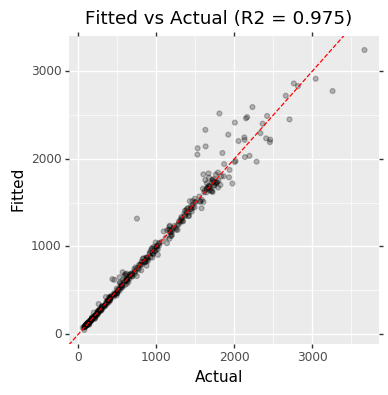

<ggplot: (113827142569)>

In [32]:
# Fit model
params_2 = {
    "boosting_type": "dart",
    "n_estimators": 1250,
    "monotone_constraints": [0, -1, 0, 0, 1, 0]
}

lgb_model_2 = lgb.LGBMRegressor(**params_2)
lgb_model_2.fit(X_train_2, y_train_2)

# Get diagnostics
diagnostics_2 = RegressionDiagnostics(lgb_model_2)
diagnostics_2.fit(X_test_2, y_test_2)

diagnostics_2.fitted_actual(sample_frac=1.0)

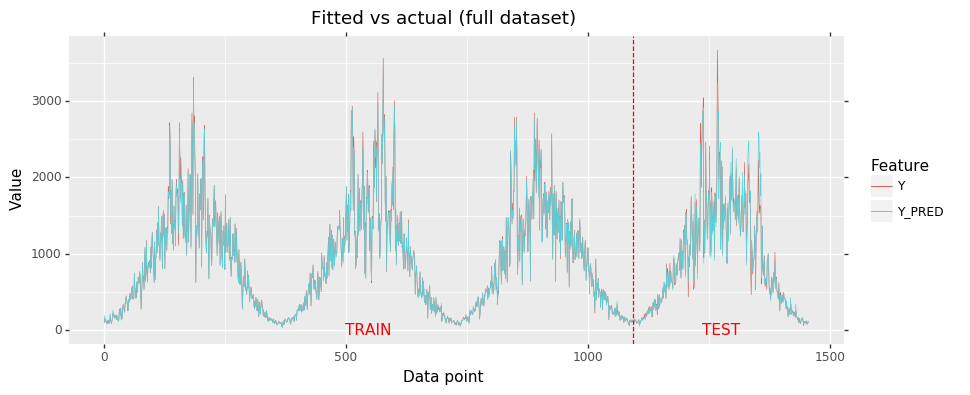

<ggplot: (113829315848)>

In [33]:
# Get predicted values for all data points
yhat_all_2 = metrics[["YEAR", "DOY"]].assign(
    Y = X_2.Y,
    Y_PRED = lgb_model_2.predict(X_2.drop("Y", axis=1))
)

# Train and test labels for plot
train_test_label_2 = pd.DataFrame(
    {"x": [split_point_2 * 0.5 ,
           split_point_2 + (metrics.shape[0] - split_point_2) * 0.5],
     "y": [0, 0],
     "label": ["TRAIN", "TEST"]})

# Plot actual vs predicted
(ggplot(yhat_all_2.drop(["YEAR", "DOY"], axis=1).reset_index().melt(
    id_vars="index"),
        aes(x="index", y="value", colour="variable")) +
 geom_line(size=0.25) +
 geom_vline(aes(xintercept=split_point_1), colour="red",
           linetype="dashed") +
 geom_text(train_test_label_2,
           aes(x="x", y="y", label="label"),
          inherit_aes=False, colour="red") +
 theme(figure_size=(10,4)) +
 labs(title="Fitted vs actual (full dataset)",
      x="Data point",
      y="Value",
      color="Feature"
      )
)

### Shapley values (exact, default DOY = 0)

In [34]:
# Calculate Shapley values
shapley_est_2a = shapley.ShapleyEstimator(model=lgb_model_2,
                                          max_iter=np.math.factorial(6),
                                          tol=-np.inf,
                                          default_values={"DOY":0, "DEAL":0,
                                                         "RAIN":0, "SUN_HOURS":0,
                                                         "MAX_TEMP":0, "MAX_TEMP_LAG1":0})
shapley_est_2a.fit(X_test_2)

Start time: 19:31:39.672087
Iteration:      1, Difference: 1.000000, Time: 19:31:39.753084, Coalitions seen: 9.52%
Iteration:      2, Difference: 0.017358, Time: 19:31:39.765084, Coalitions seen: 11.11%
Iteration:      3, Difference: 0.017991, Time: 19:31:39.779085, Coalitions seen: 12.70%
Iteration:      4, Difference: 0.024567, Time: 19:31:39.792084, Coalitions seen: 14.29%
Iteration:      5, Difference: 0.017073, Time: 19:31:39.805084, Coalitions seen: 15.87%
Iteration:      6, Difference: 0.011775, Time: 19:31:39.809083, Coalitions seen: 15.87%
Iteration:      7, Difference: 0.012207, Time: 19:31:39.822084, Coalitions seen: 17.46%
Iteration:      8, Difference: 0.010214, Time: 19:31:39.826084, Coalitions seen: 17.46%
Iteration:      9, Difference: 0.008728, Time: 19:31:39.838085, Coalitions seen: 19.05%
Iteration:     10, Difference: 0.012580, Time: 19:31:39.851084, Coalitions seen: 20.63%
Iteration:     20, Difference: 0.005289, Time: 19:31:39.931084, Coalitions seen: 26.98%
Itera

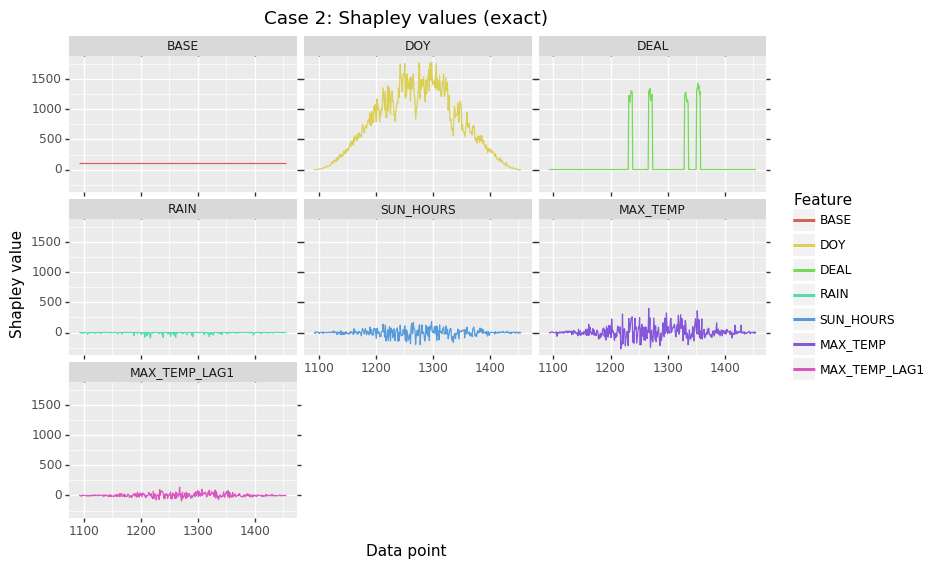

<ggplot: (-9223371923029682446)>

In [35]:
# Plot Shapley values, facetted by feature
shapley_est_2a_melt = shapley_est_2a.get_shapley_values().reset_index().melt(
    id_vars="index")
shapley_est_2a_melt = shapley_est_2a_melt.assign(
    variable = pd.Categorical(shapley_est_2a_melt["variable"],
                              categories=["BASE", "DOY", "DEAL",
                                          "RAIN", "SUN_HOURS", "MAX_TEMP",
                                          "MAX_TEMP_LAG1"],
                              ordered=False))

(ggplot(shapley_est_2a_melt,
        aes(x="index", y="value", colour="variable")) + 
 geom_line() +
 theme(figure_size = (9, 6)) +
 labs(title="Case 2: Shapley values (exact)",
     x="Data point",
     y="Shapley value",
     color="Feature") +
 facet_wrap("~variable", ncol=3)
)

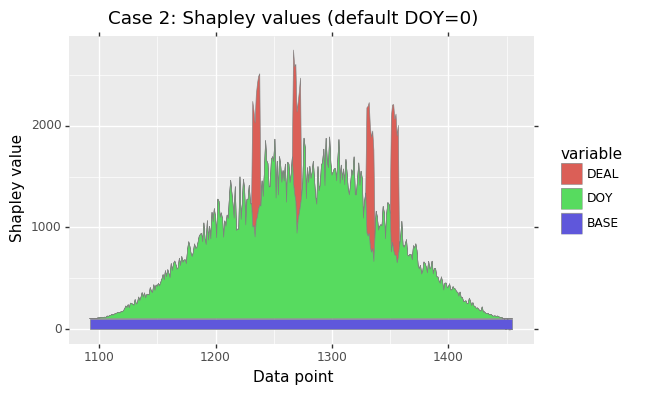

<ggplot: (113836895401)>

In [36]:
# Plot Shapley values, excluding weather features
(ggplot(shapley_est_2a_melt.query("variable in(['BASE', 'DOY', 'DEAL'])").assign(
    variable = lambda x: pd.Categorical(x["variable"],
                                       categories=["DEAL", "DOY", "BASE"],
                                       ordered=False)),
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.25) +
 theme(figure_size = (6, 4)) +
 labs(title="Case 2: Shapley values (default DOY=0)",
     x="Data point",
     y="Shapley value",
     color="Feature")
)

### Shapley values (exact, default DOY = 91)

In [37]:
# Establish base case
doy_default_2 = 91
shapley_est_base_2b = lgb_model_2.predict(
    pd.DataFrame({"DOY":[doy_default_2], "DEAL": [0],
                  "RAIN":[0], "SUN_HOURS":[0],
                  "MAX_TEMP":[0], "MAX_TEMP_LAG1":[0]}
                ))
shapley_est_base_2b

array([861.08916922])

In [38]:
# Calculate Shapley values
shapley_est_2b = shapley.ShapleyEstimator(model=lgb_model_2,
                                          max_iter=np.math.factorial(6),
                                          tol=-np.inf,
                                          default_values={"DOY":doy_default_2, "DEAL":0,
                                                         "RAIN":0, "SUN_HOURS":0,
                                                         "MAX_TEMP":0, "MAX_TEMP_LAG1":0})
shapley_est_2b.fit(X_test_2)

Start time: 19:31:44.521133
Iteration:      1, Difference: 1.000000, Time: 19:31:44.608132, Coalitions seen: 9.52%
Iteration:      2, Difference: 0.017358, Time: 19:31:44.620132, Coalitions seen: 11.11%
Iteration:      3, Difference: 0.017991, Time: 19:31:44.634132, Coalitions seen: 12.70%
Iteration:      4, Difference: 0.024567, Time: 19:31:44.647132, Coalitions seen: 14.29%
Iteration:      5, Difference: 0.017073, Time: 19:31:44.660130, Coalitions seen: 15.87%
Iteration:      6, Difference: 0.011775, Time: 19:31:44.664132, Coalitions seen: 15.87%
Iteration:      7, Difference: 0.012207, Time: 19:31:44.677132, Coalitions seen: 17.46%
Iteration:      8, Difference: 0.010214, Time: 19:31:44.681131, Coalitions seen: 17.46%
Iteration:      9, Difference: 0.008728, Time: 19:31:44.694133, Coalitions seen: 19.05%
Iteration:     10, Difference: 0.012580, Time: 19:31:44.707133, Coalitions seen: 20.63%
Iteration:     20, Difference: 0.005289, Time: 19:31:44.788131, Coalitions seen: 26.98%
Itera

In [39]:
# Put Shapley values into a dataframe
shapley_values_2b = shapley_est_2b.get_shapley_values()

shapley_values_2b = shapley_values_2b.assign(
    BASE = shapley_values_2b.BASE + min(shapley_est_2b.get_shapley_values().DOY),
    DOY = shapley_values_2b.DOY - min(shapley_est_2b.get_shapley_values().DOY)
)
shapley_values_2b

,BASE,DOY,RAIN,SUN_HOURS,MAX_TEMP,DEAL,MAX_TEMP_LAG1
1092,-76.865464,153.680867,0.000000,8.044085,-18.946721,0.0,42.872261
1093,-76.865464,158.690298,0.000000,40.729077,-12.980612,0.0,-3.391296
1094,-76.865464,274.383134,0.000000,-48.894595,-66.143038,0.0,-0.599956
1095,-76.865464,214.077300,-36.194234,39.446325,-44.422093,0.0,-10.411735
1096,-76.865464,0.000000,0.000000,54.744587,139.605290,0.0,-8.168466
...,...,...,...,...,...,...,...
1451,-76.865464,111.488900,0.000000,51.161822,43.623623,0.0,-8.013555
1452,-76.865464,132.242210,0.000000,-11.866472,42.600048,0.0,22.179888
1453,-76.865464,267.890614,0.000000,-37.948929,-96.322088,0.0,19.275705
1454,-76.865464,200.746764,0.000000,-6.532822,-11.433544,0.0,-10.619834


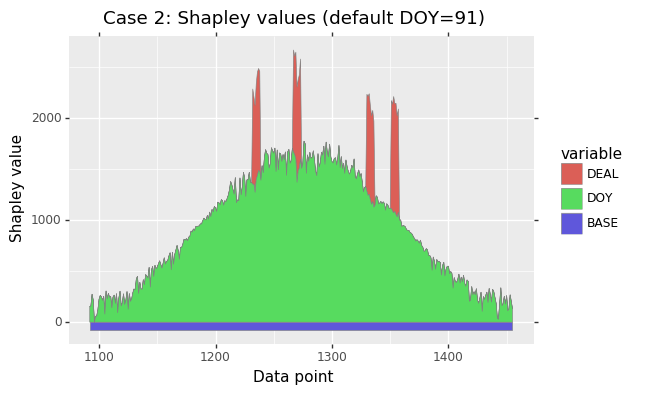

<ggplot: (113836895422)>

In [40]:
# Plot Shapley values
shapley_est_2b_melt = shapley_values_2b.reset_index().melt(
    id_vars="index")

shapley_est_2b_melt = shapley_est_2b_melt.assign(
    variable = pd.Categorical(shapley_est_2b_melt["variable"],
                              categories=["DEAL", "DOY", "BASE"],
                              ordered=False))

(ggplot(shapley_est_2b_melt.query("variable in(['BASE', 'DOY', 'DEAL'])").assign(
    variable = lambda x: pd.Categorical(x["variable"],
                                       categories=["DEAL", "DOY", "BASE"],
                                       ordered=False)),
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.25) +
 theme(figure_size = (6, 4)) +
 labs(title="Case 2: Shapley values (default DOY={})".format(doy_default_2),
     x="Data point",
     y="Shapley value",
     color="Feature")
)

### Shapley values (DOY always first)

In [41]:
# Calculate Shapley values
shapley_est_2c = shapley.ShapleyEstimator(model=lgb_model_2,
                                         max_iter=np.math.factorial(5),
                                         base_features=["DOY"],
                                         tol=-np.inf)
shapley_est_2c.fit(X_test_2)

Start time: 19:31:49.610131
Iteration:      1, Difference: 1.000000, Time: 19:31:49.683131, Coalitions seen: 16.13%
Iteration:      2, Difference: 0.020829, Time: 19:31:49.695131, Coalitions seen: 19.35%
Iteration:      3, Difference: 0.021590, Time: 19:31:49.708132, Coalitions seen: 22.58%
Iteration:      4, Difference: 0.029480, Time: 19:31:49.721132, Coalitions seen: 25.81%
Iteration:      5, Difference: 0.020487, Time: 19:31:49.734132, Coalitions seen: 29.03%
Iteration:      6, Difference: 0.014130, Time: 19:31:49.738132, Coalitions seen: 29.03%
Iteration:      7, Difference: 0.014649, Time: 19:31:49.750131, Coalitions seen: 32.26%
Iteration:      8, Difference: 0.012257, Time: 19:31:49.754131, Coalitions seen: 32.26%
Iteration:      9, Difference: 0.010473, Time: 19:31:49.766132, Coalitions seen: 35.48%
Iteration:     10, Difference: 0.015096, Time: 19:31:49.779132, Coalitions seen: 38.71%
Iteration:     20, Difference: 0.006347, Time: 19:31:49.855132, Coalitions seen: 51.61%
Iter

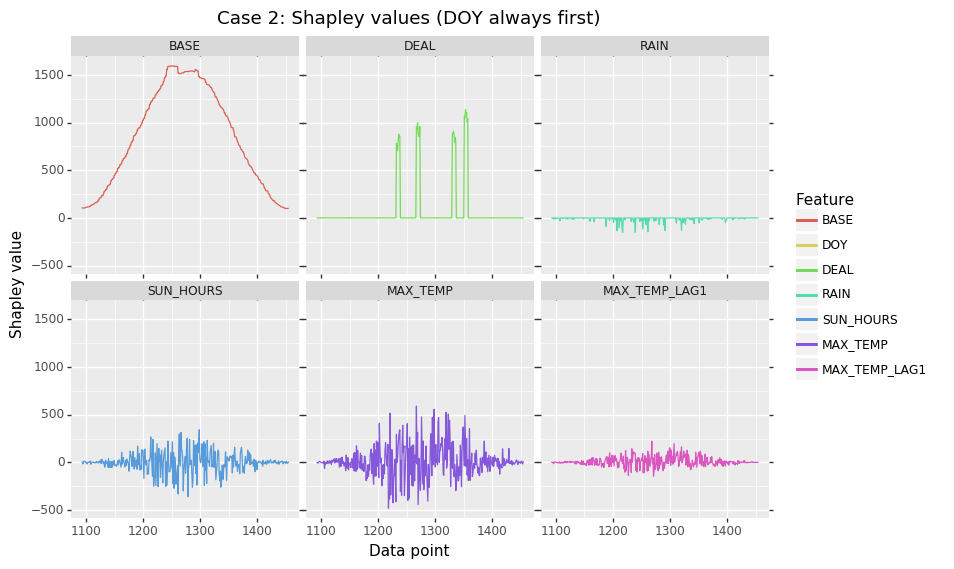

<ggplot: (-9223371923025405703)>

In [42]:
# Plot Shapley values, facetted by feature
shapley_est_2c_melt = shapley_est_2c.get_shapley_values().reset_index().melt(
    id_vars="index")
shapley_est_2c_melt = shapley_est_2c_melt.assign(
    variable = pd.Categorical(shapley_est_2c_melt["variable"],
                              categories=["BASE", "DOY", "DEAL",
                                          "RAIN", "SUN_HOURS", "MAX_TEMP",
                                          "MAX_TEMP_LAG1"],
                              ordered=False))

(ggplot(shapley_est_2c_melt,
        aes(x="index", y="value", colour="variable")) + 
 geom_line() +
 theme(figure_size = (9, 6)) +
 labs(title="Case 2: Shapley values (DOY always first)",
     x="Data point",
     y="Shapley value",
     color="Feature") +
 facet_wrap("~variable", ncol=3)
)

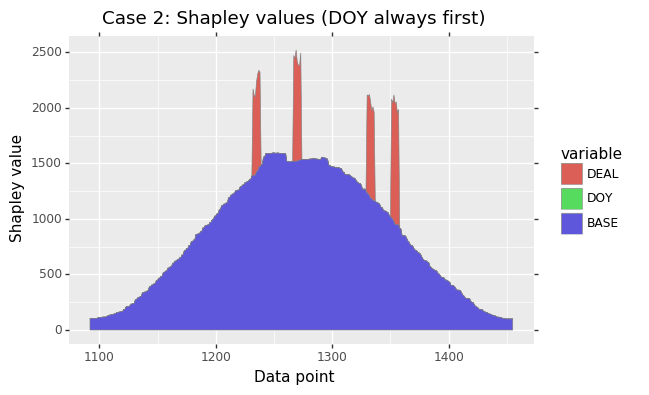

<ggplot: (-9223371923029927834)>

In [43]:
# Plot Shapley values, excluding weather features
(ggplot(shapley_est_2c_melt.query("variable in(['BASE', 'DEAL'])").assign(
    variable = lambda x: pd.Categorical(x["variable"],
                                       categories=["DEAL", "DOY", "BASE"],
                                       ordered=False)),
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.25) +
 theme(figure_size = (6, 4)) +
 labs(title="Case 2: Shapley values (DOY always first)",
     x="Data point",
     y="Shapley value",
     color="Feature")
)

### SHAP values

In [44]:
# Create SHAP explainer
explainer_2 = shap.TreeExplainer(lgb_model_2)
shap_values_2 = explainer_2.shap_values(X_test_2)

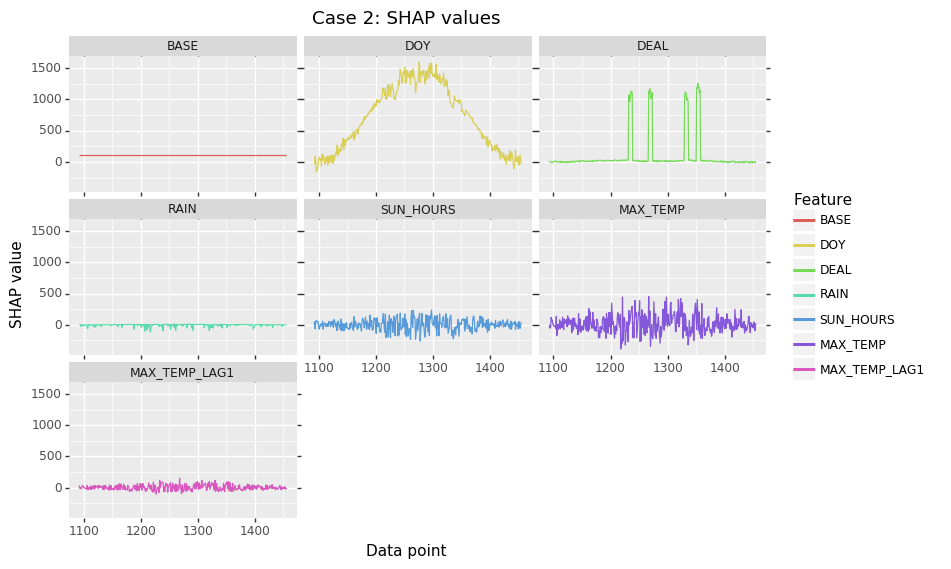

<ggplot: (113829361935)>

In [45]:
# Get shap values for DEAL==0 & DOY==0 (i.e. base case, rather than global average) 
shap_values_base_2 = explainer_2.shap_values(
    pd.DataFrame(pd.DataFrame({x:[0] for x in X_test_2.columns})))

# Subtract the base values from the SHAP output
shap_values_adj_2 = pd.DataFrame(shap_values_2 - shap_values_base_2,
                               columns=X_test_2.columns).assign(
    BASE = explainer_2.expected_value + np.sum(shap_values_base_2))

# Set index to match input data
shap_values_adj_2.set_index(
    shapley_est_2a.get_shapley_values().index,
    inplace=True)

# Melt the data frame for plotting
shap_values_adj_melt_2 = shap_values_adj_2.reset_index().melt(
    id_vars="index")
shap_values_adj_melt_2 = shap_values_adj_melt_2.assign(
    variable = pd.Categorical(shap_values_adj_melt_2["variable"],
                              categories=["BASE", "DOY", "DEAL",
                                          "RAIN", "SUN_HOURS", "MAX_TEMP",
                                          "MAX_TEMP_LAG1"],
                              ordered=False))

(ggplot(shap_values_adj_melt_2,
        aes(x="index", y="value", colour="variable")) + 
 geom_line() +
 theme(figure_size = (9, 6)) +
 labs(title="Case 2: SHAP values",
     x="Data point",
     y="SHAP value",
     color="Feature") +
 facet_wrap("~variable", ncol=3)
)

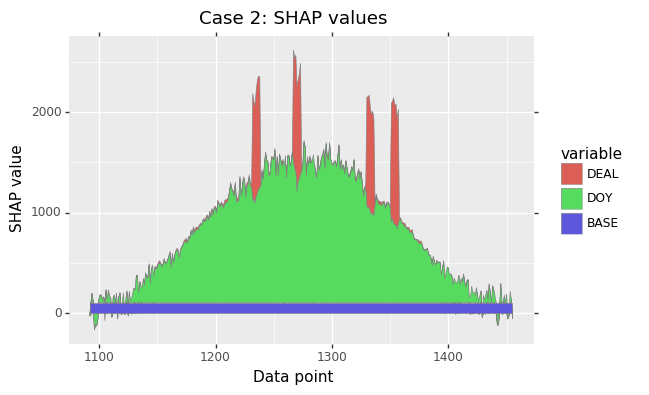

<ggplot: (113827428374)>

In [46]:
# Plot SHAP values, excluding weather metrics
(ggplot(shap_values_adj_melt_2.query("variable in(['BASE', 'DOY', 'DEAL'])").assign(
    variable = lambda x: pd.Categorical(x["variable"],
                                       categories=["DEAL", "DOY", "BASE"],
                                       ordered=False)),
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.25) +
 theme(figure_size = (6, 4)) +
 labs(title="Case 2: SHAP values",
     x="Data point",
     y="SHAP value",
     color="Feature")
)

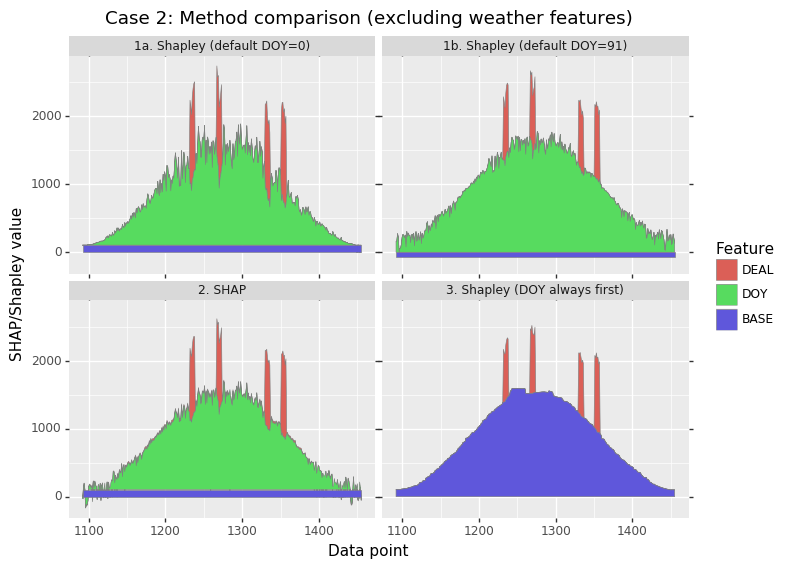

<ggplot: (113827442766)>

In [47]:
# Plot all methods
shapley_results_2 = pd.concat(
    [shapley_est_2a_melt.query("variable in(['BASE', 'DOY', 'DEAL'])").assign(
        method = "1a. Shapley (default DOY=0)"),
     shapley_est_2b_melt.query("variable in(['BASE', 'DOY', 'DEAL'])").assign(
         method = "1b. Shapley (default DOY={})".format(doy_default_2)),
     shapley_est_2c_melt.query("variable in(['BASE', 'DEAL'])").assign(
         method = "3. Shapley (DOY always first)"),
     shap_values_adj_melt_2.query("variable in(['BASE', 'DOY', 'DEAL'])").assign(
         method = "2. SHAP")])

shapley_results_2 = shapley_results_2.assign(
    variable = pd.Categorical(shapley_results_2["variable"],
                              categories=["DEAL", "DOY", "BASE"],
                              ordered=False))

(ggplot(shapley_results_2,
        aes(x="index", y="value", fill="variable")) + 
 geom_area(position="stack", alpha=1, colour="grey", size=0.25) +
 theme(figure_size = (8, 6)) +
 labs(title="Case 2: Method comparison (excluding weather features)",
     x="Data point",
     y="SHAP/Shapley value",
     fill="Feature") +
 facet_wrap("~method", ncol=2)
)

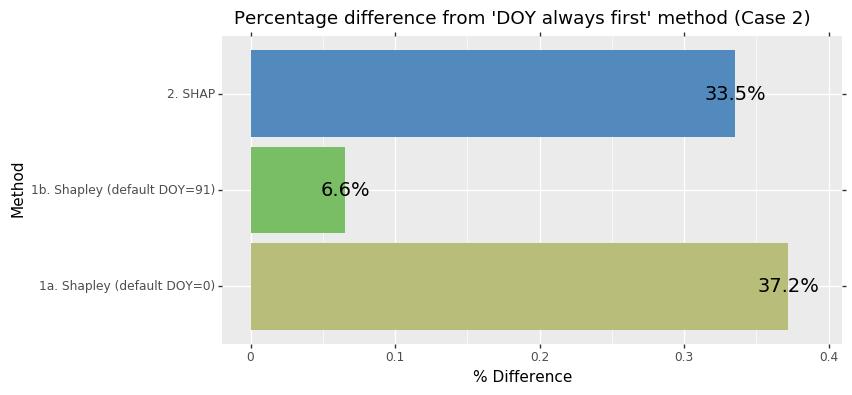

<ggplot: (113827317943)>

In [48]:
shapley_results_2_deal = shapley_results_2.drop(
    "index", axis=1).query(
    "variable == 'DEAL'").groupby(["method"], as_index=False).sum()

doy_first_2 = float(shapley_results_2_deal.query(
    "method == '3. Shapley (DOY always first)'").value)

(ggplot(shapley_results_2_deal.query(
    "method != '3. Shapley (DOY always first)'").assign(
    PC_DIFF = lambda x: x.value / doy_first_2 - 1),
        aes(x="method", y="PC_DIFF", fill="method")) +
 geom_bar(stat="identity", show_legend=False) +
 geom_text(aes(label="PC_DIFF"),
           format_string="{:3,.1%}", size=14) +
 scale_y_continuous(labels=percent_format()) +
 scale_fill_manual(["#B8BD79", "#79BD65", "#538ABD"]) +
 ylim(0,0.39) +
 theme(figure_size=(8,4)) +
 coord_flip() +
 labs(title="Percentage difference from 'DOY always first' method (Case 2)",
      x="Method",
      y="% Difference")
)

### Other comparisons

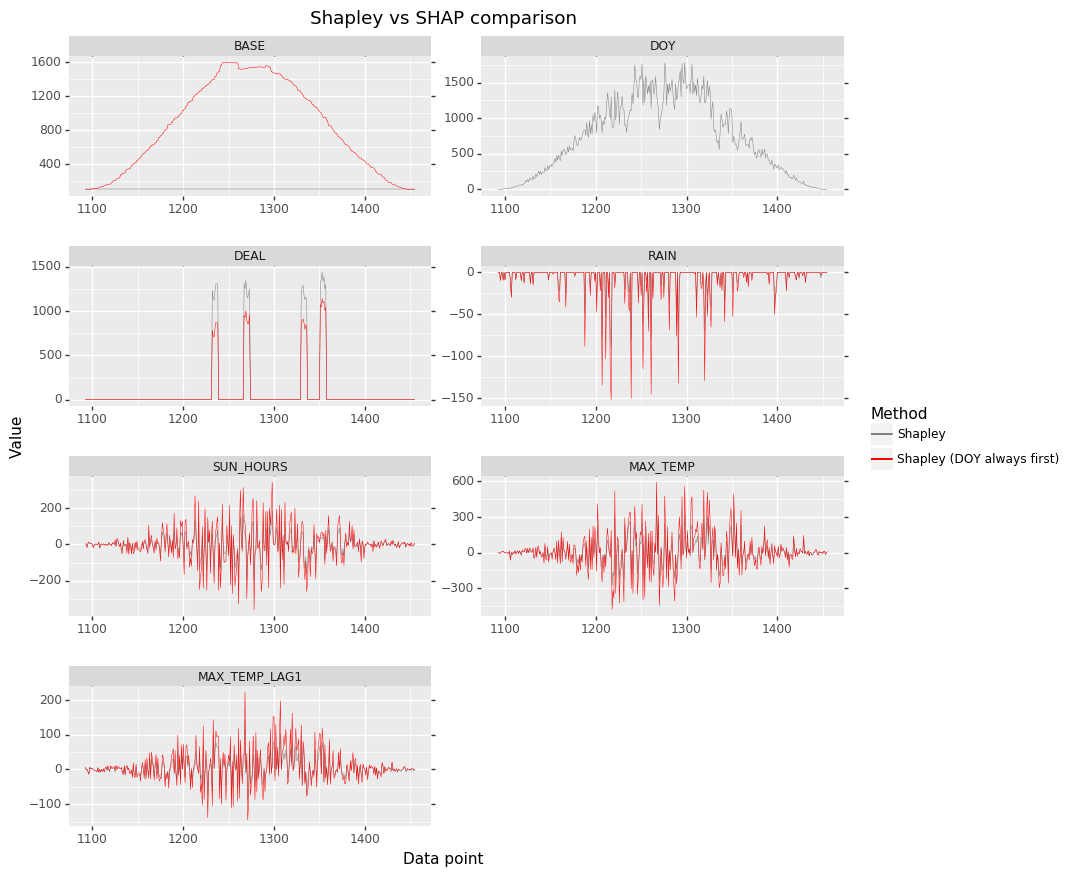

<ggplot: (113827309302)>

In [49]:
shapley_comparison_2 = pd.concat([shapley_est_2a_melt.assign(source="Shapley"),
           shapley_est_2c_melt.assign(source="Shapley (DOY always first)")])

(ggplot(shapley_comparison_2,
       aes(x="index", y="value", colour="source")) +
 geom_line(size=0.2) +
 scale_color_manual(["grey", "red"]) +
 facet_wrap("~variable", scales="free", ncol=2) +
 theme(figure_size=(10,10),
      panel_spacing=0.5) +
 labs(title="Shapley vs SHAP comparison",
     x="Data point",
     y="Value",
     color="Method")
)

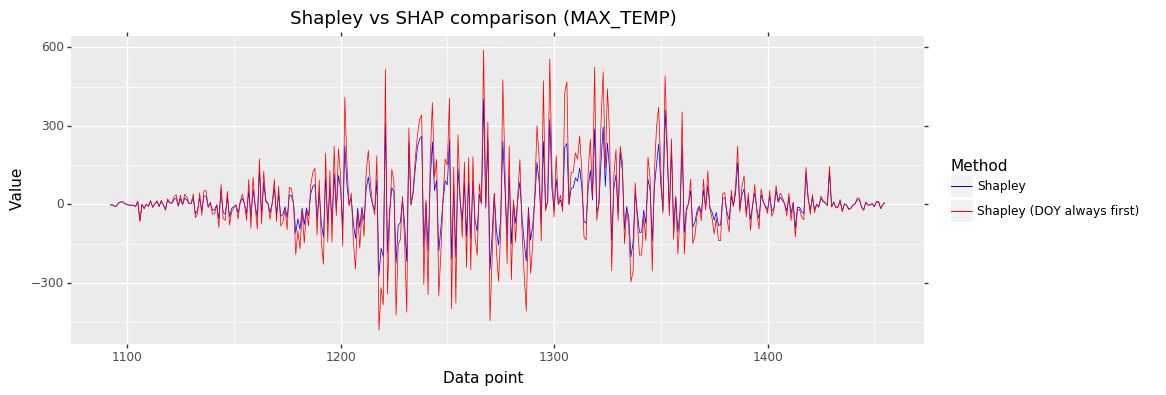

<ggplot: (113829309949)>

In [50]:
# Compare individual feature
var_2 = "MAX_TEMP"

(ggplot(shapley_comparison_2.query("variable == @var_2"),
       aes(x="index", y="value", colour="source")) +
 geom_line(size=0.3) +
 scale_color_manual(["blue", "red"]) +
 theme(figure_size=(11,4)) +
 labs(title="Shapley vs SHAP comparison (" + var_2 + ")",
     x="Data point",
     y="Value",
     color="Method")
)

### Estimated seasonality vs ground truth

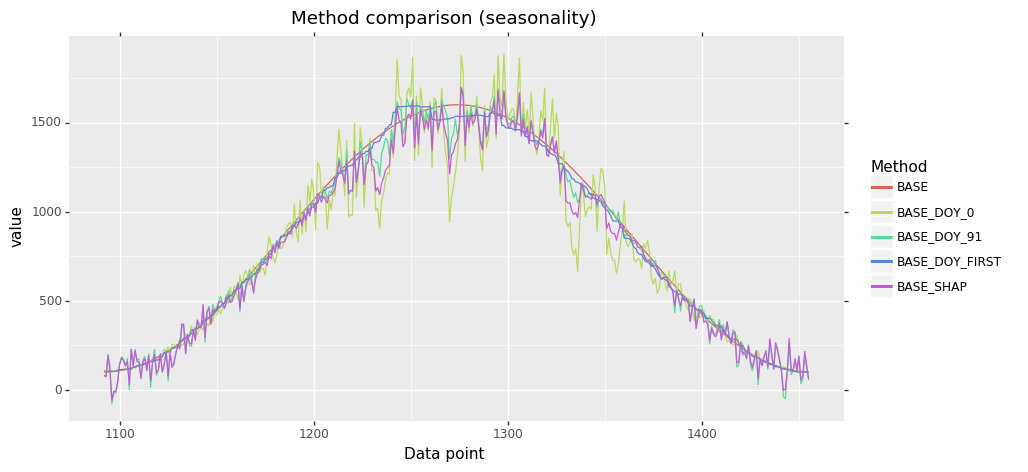

<ggplot: (113829370067)>

In [51]:
# Get seasonality (base + DOY) for each method
base_comparison = pd.DataFrame(
    metrics.index[(split_point_2-1):],columns=["ID"]).set_index("ID", drop=False).assign(
    BASE = sales[["SEASONAL"]],
    BASE_DOY_0 = shapley_est_2a.get_shapley_values()[["BASE", "DOY"]].sum(axis=1),
    BASE_DOY_91 = shapley_values_2b[["BASE", "DOY"]].sum(axis=1),
    BASE_SHAP = shap_values_adj_2[["BASE", "DOY"]].sum(axis=1),
    BASE_DOY_FIRST = shapley_est_2c.get_shapley_values()[["BASE"]]
)

base_comparison_melt = base_comparison.melt(id_vars=["ID"])

(ggplot(base_comparison_melt,
    aes(x="ID", y="value", color="variable")) +
    geom_line() +
    theme(figure_size=(10,5)) +
    labs(title="Method comparison (seasonality)",
         x="Data point",
         color="Method")
)

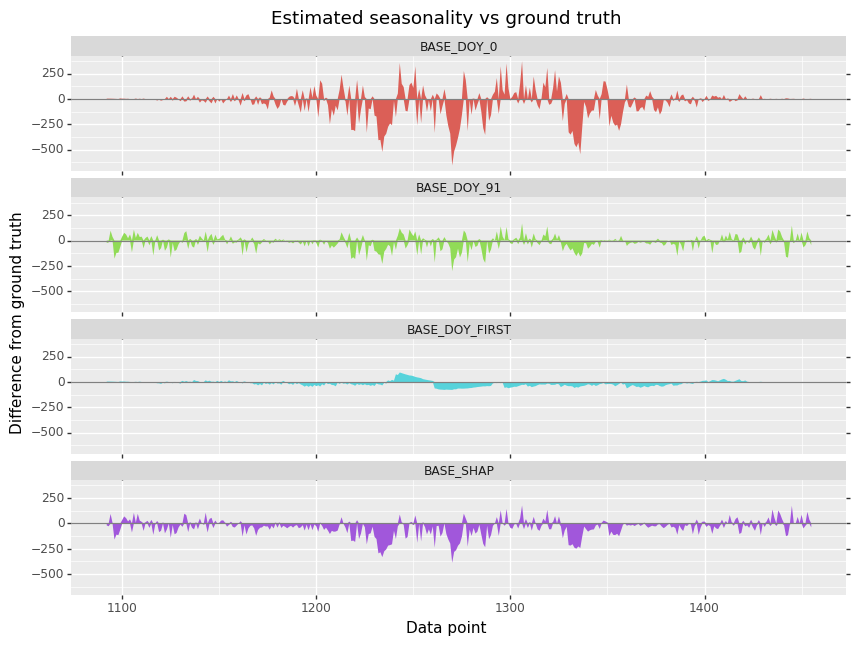

<ggplot: (113827433662)>

In [52]:
# Absolute difference
(ggplot(base_comparison.melt(id_vars=["ID", "BASE"]).assign(
    difference=lambda x: x["value"] - x["BASE"]),
        aes(x="ID", y="difference", fill="variable")) +
 geom_area() +
 geom_hline(yintercept=0, color="grey") +
 theme(figure_size=(10,7)) +
 labs(title="Estimated seasonality vs ground truth",
      x="Data point",
      y="Difference from ground truth",
      fill="Method") +
 scale_fill_discrete(guide=False) +
 facet_wrap("~variable", ncol=1)
)

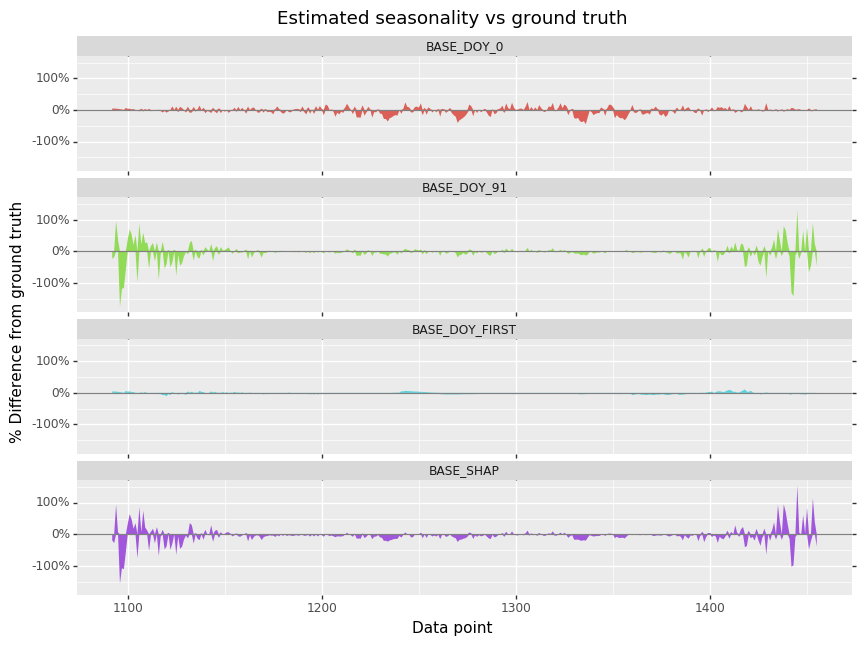

<ggplot: (-9223371923029991992)>

In [53]:
# % Difference
(ggplot(base_comparison.melt(id_vars=["ID", "BASE"]).assign(
    difference=lambda x: x["value"] / x["BASE"] - 1),
        aes(x="ID", y="difference", fill="variable")) +
 geom_area() +
 geom_hline(yintercept=0, color="grey") +
 theme(figure_size=(10,7)) +
 labs(title="Estimated seasonality vs ground truth",
      x="Data point",
      y="% Difference from ground truth",
      fill="Method") +
 scale_y_continuous(labels=percent_format()) +
 scale_fill_discrete(guide=False) +
 facet_wrap("~variable", ncol=1)
)